In [1]:
import numpy as np
from numpy import genfromtxt
from rocketpy import Function
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Definindo as funções para manipução de dados das canards

In [2]:
class Canard:
    def __init__(self, type, n, dict, radius, airfoil):
        self.type = type
        self.n = n
        self.dict = dict
        self.radius = radius
        self.airfoil = airfoil
        
        self.area = np.pi * radius**2
        self.addFins()

        #self.distanceRocketFins = distanceToCM
        Cr = dict['rootChord']
        s = dict['span']
        if self.type == 'trapezoildal':
            Ct = dict['tipChord']
            XFins = ( ((Cr - Ct) / 3) * ((Cr + 2 * Ct) / (Cr + Ct))
                    + (1 / 6) * (Cr + Ct - Cr * Ct / (Cr + Ct)))
        else:
            XFins = (0.288 * Cr)
            
        self.cpFins= XFins

    def addFins(self):
        
        # Retrieve parameters for calculations
        Cr = self.dict['rootChord']
        s = self.dict['span']
        radius = self.radius
        d = 2 * self.radius
        Aref = np.pi * radius**2
        if self.type == 'trapezoildal':
            Ct = self.dict['tipChord']
            Af = (Cr + Ct) * s / 2  # fin area
            AR = 2 * (s ** 2) / Af  # AspeCt ratio
            gamac = np.arctan((Cr - Ct) / (2 * s))  # mid chord angle
            Yr = Cr + Ct
            Lf = np.sqrt((Cr / 2 - Ct / 2) ** 2 + s ** 2)
            trapezoidalConstant = (
                (Cr + 3 * Ct) * s ** 3
                + 4 * (Cr + 2 * Ct) * radius * s ** 2
                + 6 * (Cr + Ct) * s * radius ** 2
            ) / 12
            self.trapezoidalConstant = trapezoidalConstant
        else:
            Af = (np.pi * Cr / 2 * s) / 2 # fin area
            AR = 2 * (s ** 2) / Af  # Aspeself.tipChord ratio
            gamac = 0  # mid chord angle
            ellipsoidalConstant = Cr * s * (3*np.pi*s**2 + 32 *radius * s + 12*np.pi*radius**2) / 48
            self.ellipsoidalConstant = ellipsoidalConstant 

        # Fin–body interference correction parameters
        tau = (s + radius) / radius
        if self.type == 'trapezoildal':
            λ = Ct / Cr
        else:
            CtE = Cr * (np.sqrt(9*np.pi**2 - 64)-np.pi)/(2*np.pi - np.sqrt(9*np.pi**2 -64))
            λ = CtE / Cr

        liftInterferenceFactor = 1 + 1 / tau
        rollForcingInterferenceFactor = (1 / np.pi ** 2) * (
            (np.pi ** 2 / 4) * ((tau + 1) ** 2 / tau ** 2)
            + ((np.pi * (tau ** 2 + 1) ** 2) / (tau ** 2 * (tau - 1) ** 2))
            * np.arcsin((tau ** 2 - 1) / (tau ** 2 + 1))
            - (2 * np.pi * (tau + 1)) / (tau * (tau - 1))
            + ((tau ** 2 + 1) ** 2)
            / (tau ** 2 * (tau - 1) ** 2)
            * (np.arcsin((tau ** 2 - 1) / (tau ** 2 + 1))) ** 2
            - (4 * (tau + 1))
            / (tau * (tau - 1))
            * np.arcsin((tau ** 2 - 1) / (tau ** 2 + 1))
            + (8 / (tau - 1) ** 2) * np.log((tau ** 2 + 1) / (2 * tau))
        )
        rollDampingInterferenceFactor = 1 + (
            ((tau - λ) / (tau)) - ((1 - λ) / (tau - 1)) * np.log(tau)
        ) / (
            ((tau + 1) * (tau - λ)) / (2) - ((1 - λ) * (tau ** 3 - 1)) / (3 * (tau - 1))
        )
        
        # Auxiliary functions

        # Defines beta parameter
        def beta(mach):
            if mach < 0.8:
                return np.sqrt(1 - mach ** 2)
            elif mach < 1.1:
                return np.sqrt(1 - 0.8 ** 2)
            else:
                return np.sqrt(mach ** 2 - 1)

        # Defines number of fins correction
        def finNumCorrection(n):
            correctorFactor = [2.37, 2.74, 2.99, 3.24]
            if n >= 5 and n <= 8:
                return correctorFactor[n - 5]
            else:
                return n / 2

        if not self.airfoil:
            # Defines clalpha2D as 2*pi for planar fins
            clalpha2D = Function(lambda mach: 2 * np.pi / beta(mach))
        else:
            # Defines clalpha2D as the derivative of the
            # lift coefficient curve for a specific airfoil
            airfoilCl = Function(
                self.airfoil[0],
                interpolation="linear",
            )

            # Differentiating at x = 0 to get cl_alpha
            clalpha2D_Mach0 = airfoilCl.differentiate(x=1e-3, dx=1e-3)

            # Convert to radians if needed
            if self.airfoil[1] == "degrees":
                clalpha2D_Mach0 *= 180 / np.pi

            # Correcting for compressible flow
            clalpha2D = Function(lambda mach: clalpha2D_Mach0 / beta(mach))

        if self.type == 'trapezoildal':

            # Diederich's Planform Correlation Parameter
            FD = (2*np.pi * AR) / (clalpha2D * np.cos(gamac))

            clalphaSingleFin = Function(lambda mach: ( clalpha2D(mach) * FD(mach) * (Af / Aref) * np.cos(gamac))/(2 + FD(mach) * np.sqrt(1 + 4 / FD(mach)**2)))
            

            clalphaMultipleFins = (
                liftInterferenceFactor * finNumCorrection(n) * clalphaSingleFin
            )  # Function of mach number

            # Calculates clalpha * alpha
            cl = Function(
                lambda alpha, mach: alpha * clalphaMultipleFins(mach),
                ["Alpha (rad)", "Mach"],
                "Cl",
            )

            # Save cldata
            self.cl = cl

            # Calculate roll forcing properties
            Ymac = s / 3 * (Cr + 2 * Ct) / (Cr + Ct)
            clfDelta = (
                rollForcingInterferenceFactor * n * (Ymac + radius) * clalphaSingleFin(0) / d
            ) 

            clfdata = Function(
                lambda delta: clfDelta * np.radians(delta), "Delta (rad)", "Roll forcing coeficient (Clf)", interpolation="linear"
            )

            # Save clfdata
            self.clfdata = clfdata

            cldOmega =  Function(lambda cantAngle: 2 * rollDampingInterferenceFactor * n * clalphaSingleFin(0) * np.cos(np.radians(cantAngle)) * trapezoidalConstant / (Aref * d ** 2))
            cldOmegaData = Function(lambda w, v, cantAngle: cldOmega(cantAngle) * w * d / (2*v))
            self.cld_data = cldOmegaData

            return None
        
        else:

            # Diederich's Planform Correlation Parameter
            FD = (2*np.pi * AR) / (clalpha2D * np.cos(gamac))

            clalphaSingleFin = Function(lambda mach: ( clalpha2D(mach) * FD(mach) * (Af / Aref) * np.cos(gamac))/(2 + FD(mach) * np.sqrt(1 + 4 / FD(mach)**2)))
            

            clalphaMultipleFins = (
                liftInterferenceFactor * finNumCorrection(n) * clalphaSingleFin
            )  # Function of mach number

            # Calculates clalpha * alpha
            cl = Function(
                lambda alpha, mach: alpha * clalphaMultipleFins(mach),
                ["Alpha (rad)", "Mach"],
                "Cl",
            )

            # Save cldata
            self.cl = cl

            # Calculate roll forcing properties
            Ymac = s/(3*np.pi) * np.sqrt(9*np.pi**2 - 64)
            clfDelta = (
                rollForcingInterferenceFactor * n * (Ymac + radius) * clalphaSingleFin(0) / d
            )# Function of mach

            clfdata = Function(
                lambda delta: clfDelta * np.radians(delta), "Delta (rad)", "Roll forcing coeficient (Clf)", interpolation="linear"
            )

            # Save clfdata
            self.clfdata = clfdata

            cldOmega =  Function(lambda cantAngle: 2 * rollDampingInterferenceFactor * n * clalphaSingleFin(0) * np.cos(np.radians(cantAngle)) * ellipsoidalConstant / (Aref * d ** 2))
            cldOmegaData = Function(lambda w, v, cantAngle: cldOmega(cantAngle) * w * d / (2*v))
            self.cld_data = cldOmegaData

            return None

## Inserção de dados

In [4]:
# Dados das aletas
n = 4
span = 0.125
rootChord = 0.120
tipChord = 0.08

# Dados das canards
n_canard = 2
span_canard = 0.062
rootChord_canard = 0.062
tipChord_canard = 0.062

# Dados do foguete
radius = 101.6/2000

## Criando as aletas e canards

In [13]:
Function(lambda alpha: canard.cl(alpha,0)).differentiate(0,1e-6)

3.555380410722678

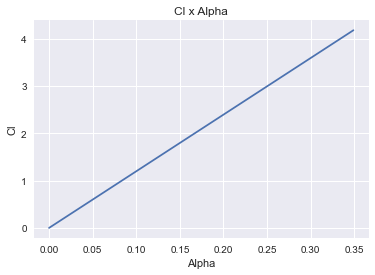

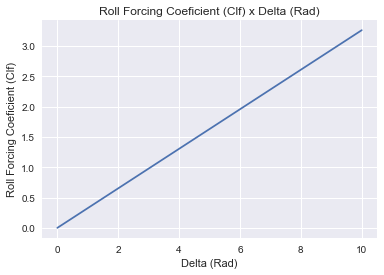

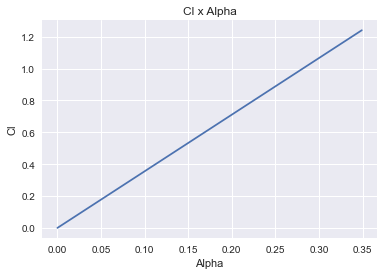

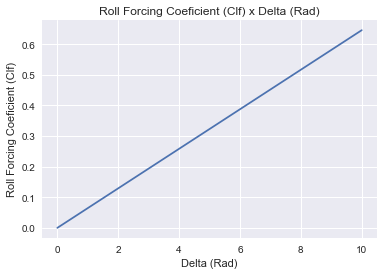

In [12]:
# Criando objeto correspondente à aleta
dictAleta = {'rootChord': rootChord,'span': span,'tipChord': tipChord}
dictCanard ={'rootChord': rootChord_canard,'span': span_canard,'tipChord': tipChord_canard}

aleta = Canard('trapezoildal', n, dictAleta, radius, ('NACA0012 curva Completa.txt','radians'))
canard = Canard('trapezoildal', n_canard, dictCanard, radius, ('xf-e473-il-1000000.csv','degrees'))
Function(lambda alpha: aleta.cl(alpha,0),'alpha','cl').plot(0,20 * np.pi / 180)
aleta.clfdata()
Function(lambda alpha: canard.cl(alpha,0),'alpha','cl').plot(0,20 * np.pi / 180)
canard.clfdata()

## Comparação

### Entradas da comparação

In [15]:
# Dados do foguete
J = 0.03421  # Momento de inercia (SI)
angulo_maximo_de_abertura = 1
angulo_maximo_de_abertura_canard = 8

# Dados sobre a condição de voo analisada
omega = 0 # rad/s (pior caso para as canards é próximo de 0 sem a ajuda do amortecimento)
velocidade = 0.5 * 343 # Mach 0.5
rho = 1.06 # air density

### Contas

In [16]:
# Parametros das aletas
forcing_aletas = aleta.clfdata(angulo_maximo_de_abertura)
damping_aletas = aleta.cld_data(omega, velocidade,angulo_maximo_de_abertura)

# Parametros das canards
forcing_canard = canard.clfdata(angulo_maximo_de_abertura_canard)
damping_canard = canard.cld_data(omega, velocidade,angulo_maximo_de_abertura_canard)

# Parametros de voo
DynamicPressure = velocidade**2 * rho / 2

# Aceleração obtida
Ar = aleta.area # Área de referencia
Lr = 2 * aleta.radius # Comprimento de referencia
omega_dot = (forcing_aletas - forcing_canard - damping_aletas - damping_canard) * DynamicPressure * Ar * Lr / J

print("Aceleração angular para V={:.0f}m/s é: ὡ = {:.2f}rad/s²".format(velocidade, omega_dot))
print("Nota 1: Deseja-se que a aceleração seja negativa para que a canard seja capaz de estabilizar o foguete")

Aceleração angular para V=172m/s é: ὡ = -71.55rad/s²
Nota 1: Deseja-se que a aceleração seja negativa para que a canard seja capaz de estabilizar o foguete


## Testando tamanhos de Canard

In [60]:
# Dados das aletas
n = 4
span = 0.125
rootChord = 0.120
tipChord = 0.08

# Dados das canards
n_canard = 2
span_canard = 0.055
rootChord_canard = 0.055
tipChord_canard = 0.055

# Dados do foguete
radius = 101.6/2000

# Criando objeto correspondente à aleta
dictAleta = {'rootChord': rootChord,'span': span,'tipChord': tipChord}
dictCanard ={'rootChord': rootChord_canard,'span': span_canard,'tipChord': tipChord_canard}
aleta = Canard('trapezoildal', n, dictAleta, radius, ('NACA0012 curva Completa.txt','radians'))
canard = Canard('trapezoildal', n_canard, dictCanard, radius, ('xf-e473-il-1000000.csv','degrees'))

# Dados do foguete
J = 0.03421 # Momento de inercia (SI)
angulo_maximo_de_abertura = 1
angulo_maximo_de_abertura_canard = 8

# Dados sobre a condição de voo analisada
omega = 0 # rad/s (pior caso para as canards é próximo de 0 sem a ajuda do amortecimento)
velocidade = 0.5 * 343 # Mach 0.5
rho = 1.06 # air density

# Parametros das aletas
forcing_aletas = aleta.clfdata(angulo_maximo_de_abertura)
damping_aletas = aleta.cld_data(omega, velocidade,angulo_maximo_de_abertura)

# Parametros das canards
forcing_canard = canard.clfdata(angulo_maximo_de_abertura_canard)
damping_canard = canard.cld_data(omega, velocidade,angulo_maximo_de_abertura_canard)

# Parametros de voo
DynamicPressure = velocidade**2 * rho / 2

# Aceleração obtida
Ar = aleta.area # Área de referencia
Lr = 2 * aleta.radius # Comprimento de referencia
omega_dot = (forcing_aletas - forcing_canard - damping_aletas - damping_canard) * DynamicPressure * Ar * Lr / J

print("Aceleração angular para V={:.0f}m/s é: ὡ = {:.2f}rad/s²".format(velocidade, omega_dot))
print("Nota 1: Deseja-se que a aceleração seja negativa para que a canard seja capaz de estabilizar o foguete")
print("Nota 2: Deve-se checar a posição do centro de pressão da canard em relação ao seu centro de massa. Deseja-se que o cp esteja abaixo do cp para que o momento gerado na própria canard seja restaurador em relação ao eixo que a perfura")

Aceleração angular para V=172m/s é: ὡ = -23.97rad/s²
Nota 1: Deseja-se que a aceleração seja negativa para que a canard seja capaz de estabilizar o foguete
Nota 2: Deve-se checar a posição do centro de pressão da canard em relação ao seu centro de massa. Deseja-se que o cp esteja abaixo do cp para que o momento gerado na própria canard seja restaurador em relação ao eixo que a perfura


In [33]:
omega_max = 30 #rad/s
omega_max/omega_dot #segundo, tempo que leva para chegar em zero

-1.2514821690375504

In [44]:
tanto_que_o_eixo_fica_pra_fora = 0.02
Mf = omega_dot * J / (101.6/2000 + 0.055/2 + (tanto_que_o_eixo_fica_pra_fora)) / 2
Mf # Nm
print("{:.10f} Nm".format(Mf))
print("{:.10f} kgfcm".format(Mf*10.197162129779283))

-4.1712493232 Nm
-42.5349056321 kgfcm


In [45]:
0.0410342139 * 3


0.12310264169999999

In [57]:
(abs(1-0.5**2))**(1/2)

0.8660254037844386

In [64]:
canard.cl(8*np.pi/180,0)

0.39868263516009894

In [70]:
MaxNormalForce

52.42557841947523

In [69]:
0.055*0.7 - canard.cpFins

0.02475

In [66]:
canard.cpFins

0.01375

In [65]:
MaxNormalForce = canard.cl(8*np.pi/180,0.5) * DynamicPressure * Ar

XCgFins = 0.055*0.7

MaxTorque = MaxNormalForce * (XCgFins - canard.cpFins)

print("Applied torque = {:.3f} Nm".format(MaxTorque))
print("Applied torque = {:.3f} kgfcm".format(MaxTorque*10.2))
print("Valores negativos significa que o centro de pressão está acima do centro de massa")

Applied torque = 1.298 Nm
Applied torque = 13.235 kgfcm
Valores negativos significa que o centro de pressão está acima do centro de massa
